In [1]:
import numpy as np
import awkward as ak
import fastjet
import uproot as ur
import matplotlib.colors as mcolors
import mplhep as hep
import matplotlib.pyplot as plt
import math
import matplotlib as colors
import matplotlib as abc
from scipy.optimize import curve_fit
import pandas as pd
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle

hep.style.use(hep.style.CMS)
hep.style.use("CMS")
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
antiktR = 0.7
input_file_reco = 'pythia8_reco.root'
input_file_gen = 'pythia8_gen.root'

In [3]:
def eta(r, z):
    theta = abs(np.arctan(r / z))
    result = np.where(z < 0, np.log(np.tan(theta / 2)), -1 * np.log(np.tan(theta / 2)))
    return result

def phi(x,y):
    return np.arctan2(y, x)

def momentum_xyz(px, py, pz):
    norm = np.sqrt(px**2 + py**2 + pz**2)
    x = px / norm
    y = py / norm
    z = pz / norm
    return x, y, z

def cart_components(P, eta, phi):
    theta = 2 * np.arctan(np.exp(eta))
    pz = P * np.cos(theta)
    r = P * np.sin(theta)
    px = r * np.cos(phi)
    py = r * np.sin(phi)
    pz = np.where(eta > 0, np.abs(pz), -1*np.abs(pz))
    return px, py, pz

def jet_dict(px, py, pz, e, minE):
    momenta = ak.zip(
    {
        "px": ak.Array(px),
        "py": ak.Array(py),
        "pz": ak.Array(pz),
        "E": ak.Array(e),
    }
    )
    lorentz = ak.Array(momenta, with_name="Momentum4D", behavior=ak.behavior)
    
    # Define the jet definition
    jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, antiktR)

    # Cluster the particles into jets
    cluster = fastjet.ClusterSequence(lorentz, jetdef)
    inc_jets = cluster.inclusive_jets()
    x, y, z = momentum_xyz(inc_jets.px, inc_jets.py, inc_jets.pz)
    jeta = eta(np.sqrt(x**2 + y**2), z)
    
    etaMin = 2.4
    etaMax = 4
    #etaMin = 0
    cut_secondary = (inc_jets.E >= minE) & (jeta >= etaMin) & (jeta <= etaMax)
    
    data_dict = {
        "energy": inc_jets.E[cut_secondary],
        "eta": jeta[cut_secondary],
        "phi": phi(x[cut_secondary], y[cut_secondary])
    }
    return data_dict

In [4]:

events = ur.open("%s:data"%(input_file_reco))
arrays = events.arrays()

posx = arrays['Cal_hit_posx']
posy = arrays['Cal_hit_posy']
posz = arrays['Cal_hit_posz']
energy = arrays['Cal_hit_energy']
detid = arrays['Cal_detid']

adcsum = arrays['Cal_adcsum']
detid = arrays['Cal_detid']

cut_primary = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==0) ^(arrays['Cal_detid']==1) ^ (arrays['Cal_detid']==2) ^ (arrays['Cal_detid']==3))
cut_HCAL = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==2) ^ (arrays['Cal_detid']==3))
cut_ECAL = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==0) ^ (arrays['Cal_detid']==1))

xcut = posx[cut_primary]
ycut = posy[cut_primary]
zcut = posz[cut_primary]
ecut = energy[cut_primary]

xHcal = posx[cut_HCAL]
yHcal = posy[cut_HCAL]
zHcal = posz[cut_HCAL]
eHcal = energy[cut_HCAL]

xEcal = posx[cut_ECAL]
yEcal = posy[cut_ECAL]
zEcal = posz[cut_ECAL]
eEcal = energy[cut_ECAL]

In [30]:
events = ur.open("%s:genevents/primaryEvent/mParticles"%(input_file_gen))
arrays = events.arrays()

cut_primary = (arrays['mParticles.mStatus'] == 1)

energygen = arrays['mParticles.mEnergy'][cut_primary]
status = arrays['mParticles.mStatus'][cut_primary]
Px = arrays['mParticles.mPx'][cut_primary]
Py = arrays['mParticles.mPy'][cut_primary]
Pz = arrays['mParticles.mPz'][cut_primary]

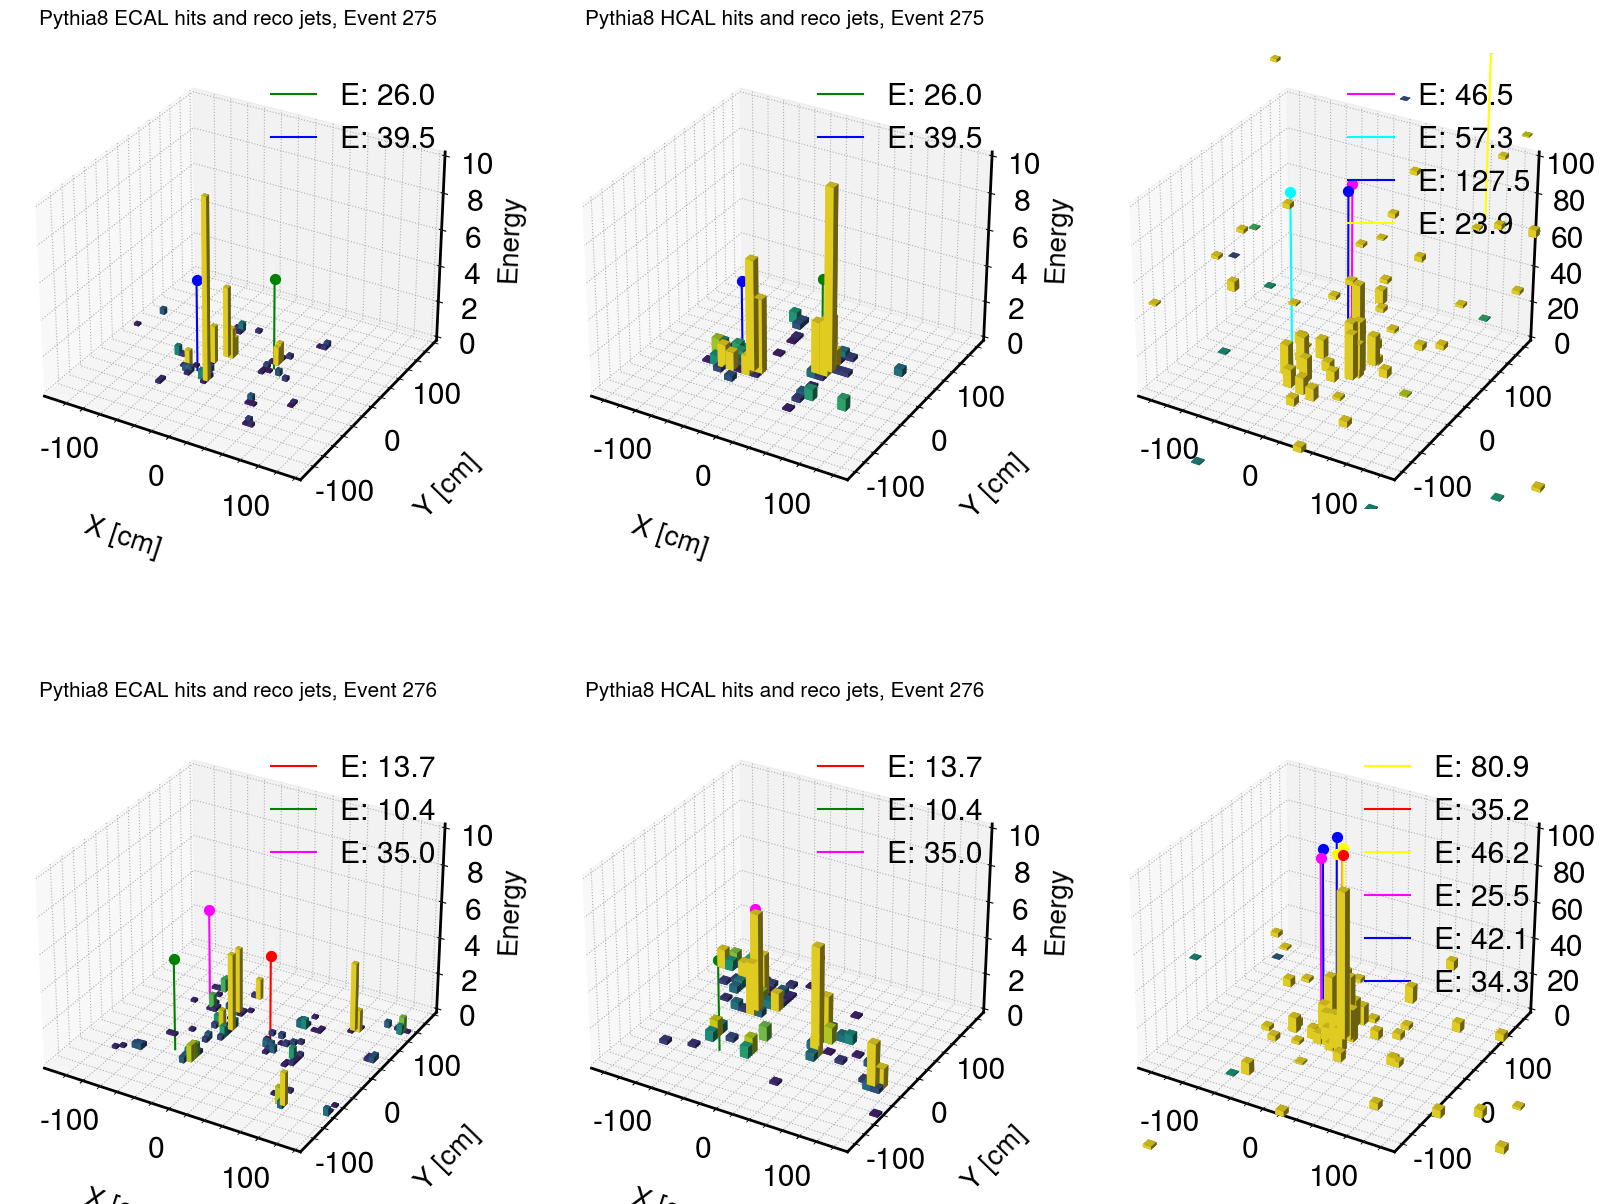

In [37]:
n = 2

fig, axs = plt.subplots(nrows=n, ncols=3, subplot_kw={'projection': '3d'}, figsize=(20, 8*n))

inferno = plt.get_cmap('viridis')
cmap = plt.get_cmap('viridis')
colors = ["red","green","blue","cyan","magenta","yellow"]
start = 275

for i in range(start, start+n):
    
    norms = np.sqrt(xcut[i]**2 + ycut[i]**2 + zcut[i]**2)
    px = (xcut[i] / norms) * ecut[i]
    py = (ycut[i] / norms) * ecut[i]
    pz = (zcut[i] / norms) * ecut[i]
    e = ecut[i]
    momenta = ak.zip(
    {
        "px": ak.Array(px),
        "py": ak.Array(py),
        "pz": ak.Array(pz),
        "E": ak.Array(e),
    }
    )
    lorentz = ak.Array(momenta, with_name="Momentum4D", behavior=ak.behavior)
    
    # Define the jet definition
    jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, antiktR)

    # Cluster the particles into jets
    cluster = fastjet.ClusterSequence(lorentz, jetdef)
    inc_jets = cluster.inclusive_jets()
    x, y, z = momentum_xyz(inc_jets.px, inc_jets.py, inc_jets.pz)
    jetE = inc_jets.E
    jetXH = 806 * x / z
    jetYH = 806 * y / z

    jetXE = 724 * x / z
    jetYE = 724 * y / z

    
    evt=i
    ax = axs[i-start][0]
    ax.set_title(f'Pythia8 ECAL hits and reco jets, Event {evt}', fontsize=15, pad=20)
    ax.bar3d(np.array(xEcal[evt]), np.array(yEcal[evt]), 0, 5.5694733, 5.572006, np.array(eEcal[evt]), color=[cmap(k) for k in np.array(eEcal[evt])])
    ax.set_zlim(0, 10)
    ax.set_xlim(-140, 140)
    ax.set_ylim(-140, 140)
   
    ax.set_xlabel('X [cm]', fontsize=20)
    ax.set_ylabel('Y [cm]', fontsize=20)
    ax.set_zlabel('Energy', fontsize=20)

    ax.yaxis.labelpad=30
    ax.xaxis.labelpad=30
    ax.zaxis.labelpad=10

    for j in range(len(np.array(jetE))):
        if jetE[j] > 10:
            x_pos = jetXE[j]
            y_pos = jetYE[j]
            z_pos = jetE[j]
            ax.scatter(x_pos, y_pos, 5, s=50, color=colors[j%6], marker='o')
            ax.plot([x_pos, x_pos], [y_pos, y_pos], [0, 5], color=colors[j%6], label="E: %2.1f"%(z_pos))
            ax.legend(loc="upper right")

    
    ax = axs[i-start][1]
    ax.set_title(f'Pythia8 HCAL hits and reco jets, Event {evt}', fontsize=15, pad=20)
    ax.bar3d(np.array(xHcal[evt]), np.array(yHcal[evt]), 0, 9.985443, 9.98999, np.array(eHcal[evt]), color=[cmap(k) for k in np.array(eHcal[evt])])

    ax.set_zlim(0, 10)
    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)
    
    ax.set_xlabel('X [cm]', fontsize=20)
    ax.set_ylabel('Y [cm]', fontsize=20)
    ax.set_zlabel('Energy', fontsize=20)

    ax.yaxis.labelpad=30
    ax.xaxis.labelpad=30
    ax.zaxis.labelpad=10

    for j in range(len(np.array(jetE))):
        if jetE[j] > 10:
            x_pos = jetXH[j]
            y_pos = jetYH[j]
            z_pos = jetE[j]
            ax.scatter(x_pos, y_pos, 5, s=50, color=colors[j%6], marker='o')
            ax.plot([x_pos, x_pos], [y_pos, y_pos], [0, 5], color=colors[j%6], label="E: %2.1f"%(z_pos))
            ax.legend(loc="upper right")

    ax = axs[i-start][2]
    x, y, z = momentum_xyz(Px[i], Py[i], Pz[i])
    genX = 806 * x / z
    genY = 806 * y / z
    ax.bar3d(np.array(genX), np.array(genY), 0, 10, 10, np.array(energygen[i]), color=[cmap(k) for k in np.array(energygen[i])])
    
    momenta = ak.zip(
    {
        "px": ak.Array(Px[i]),
        "py": ak.Array(Py[i]),
        "pz": ak.Array(Pz[i]),
        "E": ak.Array(energy[i]),
    }
    )
    lorentz = ak.Array(momenta, with_name="Momentum4D", behavior=ak.behavior)
    
    # Define the jet definition
    jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, antiktR)

    # Cluster the particles into jets
    cluster = fastjet.ClusterSequence(lorentz, jetdef)
    inc_jets = cluster.inclusive_jets()
    x, y, z = momentum_xyz(inc_jets.px, inc_jets.py, inc_jets.pz)
    jetE = inc_jets.E
    jetXH = 806 * x / z
    jetYH = 806 * y / z
    for j in range(len(np.array(jetE))):
        if jetE[j] > 20:
            x_pos = jetXH[j]
            y_pos = jetYH[j]
            z_pos = jetE[j]
            ax.scatter(x_pos, y_pos, 100, s=50, color=colors[j%6], marker='o')
            ax.plot([x_pos, x_pos], [y_pos, y_pos], [0, 100], color=colors[j%6], label="E: %2.1f"%(z_pos))
            ax.legend(loc="upper right")

    
    ax.set_zlim(0, 100)
    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)


